In [1]:
import pyspark as ps
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import logging
import pandas as pd
import numpy as np

In [13]:
import pyspark as ps
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import logging
import pandas as pd
import numpy as np


class RecipeRecommender():
    """
    Recommendation engine class - uses MLLib Alternating Least Squares Model
    """

    def __init__(self, rank=250, reg=0.1):
        """ Initializes Spark and ALS model selection """
        spark = (
            ps.sql.SparkSession.builder
            .master('local[4]')
            .appName('BVS')
            .getOrCreate()
        )
        self.spark = spark
        self.sc = self.spark.sparkContext

        self.model = ALS(
            maxIter=5,
            rank=rank,
            itemCol='recipe_id',
            userCol='user_id',
            ratingCol='rating',
            nonnegative=True,
            regParam=reg,
#             coldStartStrategy="drop"
            )


    def fit(self, ratings):
        """
        Trains the recommender on a given set of ratings.

        Parameters
        ----------
        ratings : pandas dataframe, shape = (n_ratings, 4)
                  with columns 'user', 'recipe', 'rating'

        Returns
        -------
        self : object
            Returns self.
        """
        """ Convert a Pandas DF to a Spark DF """
        ratings_df = self.spark.createDataFrame(ratings)
        """
        Train the ALS model. We'll call the trained model `recommender`.
        """
        self.recommender_ = self.model.fit(ratings_df)
        return self


    def transform(self, requests):
        """
        Predicts the ratings for a given set of user_id/recipe_id pairs.

        Parameters
        ----------
        requests : pandas dataframe, shape = (n_ratings, 2)
                  with columns 'user', 'movie'

        Returns
        -------
        dataframe : a pandas dataframe with columns 'user', 'movie', 'rating'
                    column 'rating' containing the predicted rating
        """
        # Convert a Pandas DF to a Spark DF
        requests_df = self.spark.createDataFrame(requests)
        self.predictions = self.recommender_.transform(requests_df)
        return self.predictions.toPandas()


    def evaluate(self, requests, pred_col='prediction'):
        requests_df = self.spark.createDataFrame(requests)
        evaluator = RegressionEvaluator(
                metricName="rmse",
                labelCol="rating",
                predictionCol=pred_col
            )
        rmse = evaluator.evaluate(requests_df)
        return rmse

    def recommend_for_all(self, who='users', number=10):
        if who == 'users':
            user_recs = self.recommender_.recommendForAllUsers(number)
            return (user_recs.toPandas())
        else:
            recipe_recs = self.recommender_.recommendForAllItems(number)
            return (recipe_recs.toPandas)

    def model_save(self, filepath):
        self.recommender_.save(self.sc, filepath)


if __name__ == "__main__":
    pass


In [3]:
df = pd.read_csv('data/f52_user_item_rating.csv')

In [5]:
del df['Unnamed: 0']

In [8]:
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import mean_squared_error

In [9]:
y = df['rating'].values
X = df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_df = pd.DataFrame(X_train)
test_df = pd.DataFrame(X_test)
cols = 'user_id recipe_id rating'.split()
train_df.columns = cols
test_df.columns = cols
test_df_preds = test_df[['user_id', 'recipe_id']]

In [17]:
def rmse(preds, train_df, test_df):
    train_rating_mean = train_df['rating'].mean()
    new_df = preds.merge(test_df, how='left', on=['user_id', 'recipe_id'])
    new_df['user_bias'] = new_df['user_id'].apply(user_bias)
    new_df['recipe_bias'] = new_df['recipe_id'].apply(recipe_bias)
    new_df['total_bias'] = new_df['recipe_bias'] + new_df['user_bias']
    new_df['adjusted'] = new_df['prediction'] + new_df['total_bias']
    new_df['adjusted'].fillna(new_df['total_bias'].apply(lambda x: train_rating_mean + x ), inplace=True)
    y_pred = new_df['adjusted']
    y_true = new_df['rating']
    return np.sqrt(mean_squared_error(y_true, y_pred))

def user_bias(col):
    user_groups = train_df['rating'].mean() - train_df.groupby('user_id')['rating'].mean()
    if col in user_groups.index:
        return user_groups[col]
    else:
        return 0

def recipe_bias(col):
    recipe_groups = train_df['rating'].mean() - train_df.groupby('recipe_id')['rating'].mean()
    if col in recipe_groups:
        return recipe_groups[col]
    else:
        return 0

In [14]:
rec_f52 = RecipeRecommender()

In [15]:
rec_f52.fit(train_df)

<__main__.RecipeRecommender instance at 0x10be2d830>

In [16]:
preds = rec_f52.transform(test_df_preds)

In [18]:
mse_score = rmse(preds, train_df, test_df)

In [19]:
mse_score

1.6050725924712959

In [20]:
def optimization(train_df, test_df_preds, test_df):
    output = []
    params = {'rank':[1, 2, 5, 10, 50, 250], 'reg':[0.01, 0.1, 0.5, 1]}
    combi = list(ParameterGrid(params))
    for dct in combi:
        rank, reg = dct['rank'], dct['reg']
        model = RecipeRecommender(rank, reg)
        model.fit(train_df)
        preds = model.transform(test_df_preds)
        rmse_score = rmse(preds, train_df, test_df)
        output.append([rank, reg, rmse_score])
    return output

In [21]:
opt_list = optimization(train_df, test_df_preds, test_df)

In [22]:
opt_list

[[1, 0.01, 1.5412405938002069],
 [1, 0.1, 1.4688077430443554],
 [1, 0.5, 1.5400665911187938],
 [1, 1, 1.7427019178949266],
 [2, 0.01, 1.685083987106158],
 [2, 0.1, 1.5295063254617678],
 [2, 0.5, 1.554794494500024],
 [2, 1, 1.7461627983047892],
 [5, 0.01, 1.7583376463625855],
 [5, 0.1, 1.5683509584718498],
 [5, 0.5, 1.5673794231656855],
 [5, 1, 1.7502879575242445],
 [10, 0.01, 1.7097559712088928],
 [10, 0.1, 1.5850047637328333],
 [10, 0.5, 1.5780648784179816],
 [10, 1, 1.7551175365650202],
 [50, 0.01, 1.706804467864077],
 [50, 0.1, 1.6013840611342842],
 [50, 0.5, 1.5861837994438892],
 [50, 1, 1.7588069520068839],
 [250, 0.01, 1.7499539408508034],
 [250, 0.1, 1.6050725924712959],
 [250, 0.5, 1.5861912829178673],
 [250, 1, 1.7585571297363245]]

In [23]:
df_opt = pd.DataFrame.from_records(opt_list)

In [26]:
df_opt.columns = 'rank reg rmse'.split()

In [27]:
df_opt['rmse'].min()

1.4688077430443554

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117c6c310>]], dtype=object)

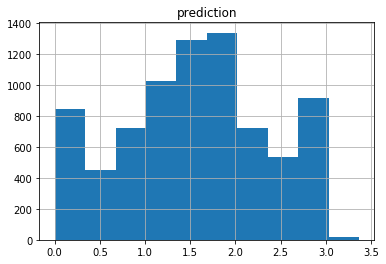

In [29]:
%matplotlib inline
preds.hist('prediction')